In [1]:
import librosa
import numpy as np

def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [2]:
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to the full UrbanSound dataset 
generalSoundPath = 'Audio-Classification/General-Sounds/'
legalVoicePath = 'Audio-Classification/User-Voices/Legal-Voices/'
illegalVoicePath = 'Audio-Classification/User-Voices/Illegal-Voices/'

features = []

for dirpath, dirnames, filenames in os.walk(generalSoundPath):
    for filename in filenames:
        file_name = os.path.join(dirpath, filename)
        
        class_label = 'General Sound'
        data = extract_features(file_name)

        features.append([data, class_label])
        
for dirpath, dirnames, filenames in os.walk(legalVoicePath):
    for filename in filenames:
        file_name = os.path.join(dirpath, filename)
        
        class_label = 'Legal Voice'
        data = extract_features(file_name)

        features.append([data, class_label])
        
for dirpath, dirnames, filenames in os.walk(illegalVoicePath):
    for filename in filenames:
        file_name = os.path.join(dirpath, filename)
        
        class_label = 'Illegal Voice'
        data = extract_features(file_name)

        features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from', len(featuresdf), 'files')

Finished feature extraction from 7361 files


In [3]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [4]:
# split the dataset 
from sklearn.model_selection import train_test_split 
from collections import Counter

x_temp, x_test, y_temp, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state = 42)

print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_val, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({2: 1849, 0: 1527, 1: 1040})
Counter({2: 644, 0: 473, 1: 355})
Counter({2: 588, 0: 552, 1: 333})


In [5]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [6]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [7]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

In [8]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_val, y_val), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
138/138 [==============================] - 5s 13ms/step - loss: 8.7845 - accuracy: 0.4549 - val_loss: 0.8874 - val_accuracy: 0.6230

Epoch 00001: val_loss improved from inf to 0.88738, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 2/100
138/138 [==============================] - 1s 6ms/step - loss: 1.7967 - accuracy: 0.5208 - val_loss: 0.9253 - val_accuracy: 0.6352

Epoch 00002: val_loss did not improve from 0.88738
Epoch 3/100
138/138 [==============================] - 1s 7ms/step - loss: 1.0558 - accuracy: 0.5630 - val_loss: 0.8817 - val_accuracy: 0.6236

Epoch 00003: val_loss improved from 0.88738 to 0.88167, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 4/100
138/138 [==============================] - 1s 7ms/step - loss: 0.9291 - accuracy: 0.6089 - val_loss: 0.8248 - val_accuracy: 0.6250

Epoch 00004: val_loss improved from 0.88167 to 0.82479, saving model to saved_models\weights.best.basic_mlp.hdf5
Epoch 5/100
138/138 [================

138/138 [==============================] - 1s 8ms/step - loss: 0.3030 - accuracy: 0.8832 - val_loss: 0.2846 - val_accuracy: 0.8886

Epoch 00035: val_loss did not improve from 0.27038
Epoch 36/100
138/138 [==============================] - 1s 7ms/step - loss: 0.3102 - accuracy: 0.8788 - val_loss: 0.2824 - val_accuracy: 0.9049

Epoch 00036: val_loss did not improve from 0.27038
Epoch 37/100
138/138 [==============================] - 1s 7ms/step - loss: 0.2975 - accuracy: 0.8745 - val_loss: 0.2866 - val_accuracy: 0.9042

Epoch 00037: val_loss did not improve from 0.27038
Epoch 38/100
138/138 [==============================] - 1s 7ms/step - loss: 0.2890 - accuracy: 0.8893 - val_loss: 0.2847 - val_accuracy: 0.8981

Epoch 00038: val_loss did not improve from 0.27038
Epoch 39/100
138/138 [==============================] - 1s 7ms/step - loss: 0.2844 - accuracy: 0.8902 - val_loss: 0.2693 - val_accuracy: 0.9076

Epoch 00039: val_loss improved from 0.27038 to 0.26927, saving model to saved_models

138/138 [==============================] - 1s 7ms/step - loss: 0.1945 - accuracy: 0.9269 - val_loss: 0.2567 - val_accuracy: 0.9110

Epoch 00074: val_loss did not improve from 0.22424
Epoch 75/100
138/138 [==============================] - 1s 7ms/step - loss: 0.2066 - accuracy: 0.9244 - val_loss: 0.2400 - val_accuracy: 0.9185

Epoch 00075: val_loss did not improve from 0.22424
Epoch 76/100
138/138 [==============================] - 1s 7ms/step - loss: 0.2002 - accuracy: 0.9237 - val_loss: 0.2585 - val_accuracy: 0.9096

Epoch 00076: val_loss did not improve from 0.22424
Epoch 77/100
138/138 [==============================] - 1s 6ms/step - loss: 0.2063 - accuracy: 0.9271 - val_loss: 0.2601 - val_accuracy: 0.9069

Epoch 00077: val_loss did not improve from 0.22424
Epoch 78/100
138/138 [==============================] - 1s 6ms/step - loss: 0.1999 - accuracy: 0.9207 - val_loss: 0.2476 - val_accuracy: 0.9103

Epoch 00078: val_loss did not improve from 0.22424
Epoch 79/100
138/138 [===========

In [10]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9719203114509583
Validation Accuracy:  0.932744562625885
Testing Accuracy:  0.9219280481338501


['General Sound' 'Illegal Voice' 'Legal Voice']


C:\Users\user\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[476   2  74]
 [  5 318  10]
 [ 14  10 564]]


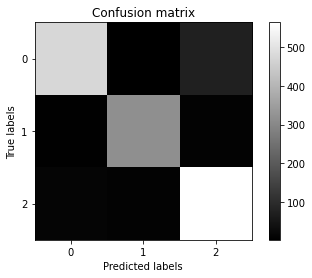

               precision    recall  f1-score   support

General Sound       0.96      0.86      0.91       552
Illegal Voice       0.96      0.95      0.96       333
  Legal Voice       0.87      0.96      0.91       588

     accuracy                           0.92      1473
    macro avg       0.93      0.93      0.93      1473
 weighted avg       0.93      0.92      0.92      1473



In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

print(le.classes_)

y_true = np.argmax(y_test, axis=1)
y_pred = model.predict_classes(x_test)
confusion_mat = confusion_matrix(y_true, y_pred)
print(confusion_mat)

plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Confusion matrix')
plt.colorbar()
ticks = np.arange(3)
plt.xticks(ticks, ticks)
plt.yticks(ticks, ticks)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

print(classification_report(y_true, y_pred, target_names=le.classes_))

In [11]:
def print_prediction(file_name):
    prediction_feature = np.array([extract_features(file_name)])

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [12]:
filename = 'V-YT-PSY-006051.wav'
# Legal
print_prediction(filename)

The predicted class is: Illegal Voice 

General Sound 		 :  0.10170454531908035278320312500000
Illegal Voice 		 :  0.46201741695404052734375000000000
Legal Voice 		 :  0.43627810478210449218750000000000


C:\Users\user\anaconda3\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
C:\Users\user\anaconda3\lib\site-packages\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
